In [1]:
#bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
#import holidays
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
#importar dados
df = pd.read_excel("estatisticas\\dados_originais_atlas.xlsx")
df["data"] = "1/" + df.mes.astype("str") + "/" + df.ano.astype("str")
df["data"] = pd.to_datetime(df.data, format="%d/%m/%Y", dayfirst=True)
df["periodo"] = df.data.dt.to_period("M")
df = df[["periodo", "codigo", "venda"]].groupby(["periodo", "codigo"]).sum().reset_index()

In [4]:
df.head()

,periodo,codigo,venda
0,2018-01,1311001,381.0
1,2018-01,1312001,1039.0
2,2018-01,1313001,1231.0
3,2018-01,1321001,125.0
4,2018-01,1322001,328.0


<positron-console-cell-75>:2: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.


<Axes: title={'center': 'Total de vendas por mês'}, xlabel='periodo'>

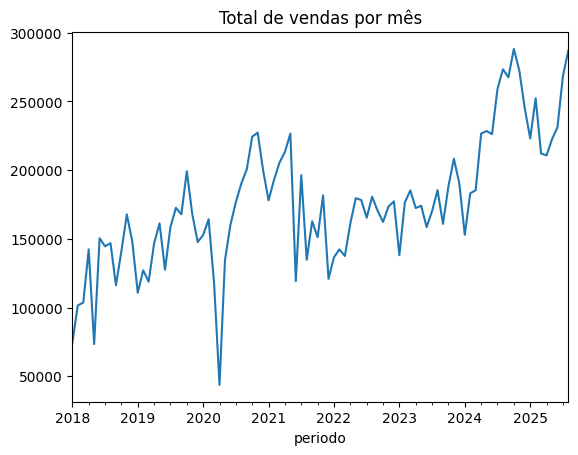

In [75]:
# Observar a continuidade dos dados
df.set_index("periodo").resample("M")["venda"].sum().plot(title="Total de vendas por mês")

In [76]:
df.head()

,periodo,codigo,venda,aquisicao_imob,contrucao_imobiliaria,IBC_atividade_economica,ind_custo_credito,geral_ipca,ipca_artigos_residencia,reforma_ou_ampliacao,tax_desocupacao,inadimplencia,fabri_eletrodomesticos,fabricacao_fogoes_refrig_maq_lavar_seca,fabri_outros_eletrodomesticos
0,2018-01,1311001,381.0,461.42,33.71,1.03,21.33,NaN,NaN,NaN,12.3,3.39,100.40956,100.99201,98.9151
1,2018-01,1312001,1039.0,461.42,33.71,1.03,21.33,NaN,NaN,NaN,12.3,3.39,100.40956,100.99201,98.9151
2,2018-01,1313001,1231.0,461.42,33.71,1.03,21.33,NaN,NaN,NaN,12.3,3.39,100.40956,100.99201,98.9151
3,2018-01,1321001,125.0,461.42,33.71,1.03,21.33,NaN,NaN,NaN,12.3,3.39,100.40956,100.99201,98.9151
4,2018-01,1322001,328.0,461.42,33.71,1.03,21.33,NaN,NaN,NaN,12.3,3.39,100.40956,100.99201,98.9151


## Criar cluster

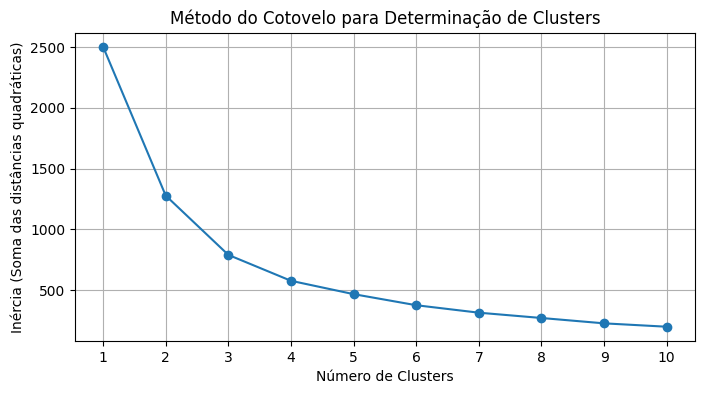

In [77]:
# Criar features agregadas para cada produto
product_features = df.groupby('codigo').agg({
    'venda': ['mean', 'std', 'count'],
}).fillna(0)

# Ajustar os nomes das colunas (remover multi-index)
product_features.columns = ['y_mean', 'y_std', 'y_count']

# Padronização dos dados
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features)

# Método do cotovelo para determinar o número ideal de clusters
inertia = []
k_range = range(1, 11)  # Testando de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(product_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo para Determinação de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

<Axes: title={'center': 'Distribuição de tamanho da série por filial'}>

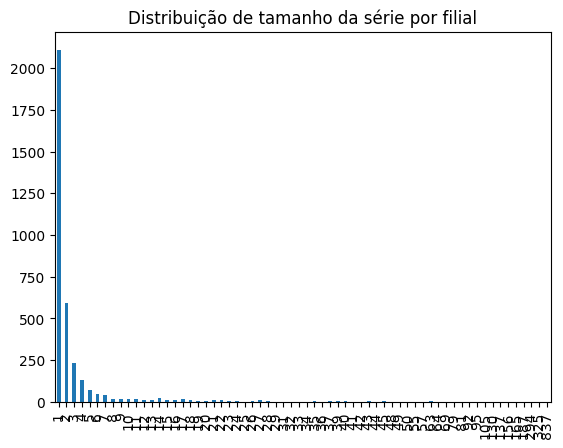

In [94]:
#Ver quantos produtos têm histórico curto
df[df.venda >= 0].groupby(["venda"]).size().value_counts().sort_index().plot(kind="bar", title="Distribuição de tamanho da série por filial")

In [97]:
df.columns

Index(['periodo', 'codigo', 'venda', 'aquisicao_imob', 'contrucao_imobiliaria', 'IBC_atividade_economica', 'ind_custo_credito',
       'geral_ipca', 'ipca_artigos_residencia', 'reforma_ou_ampliacao', 'tax_desocupacao', 'inadimplencia', 'fabri_eletrodomesticos',
       'fabricacao_fogoes_refrig_maq_lavar_seca', 'fabri_outros_eletrodomesticos'],
      dtype='object')

In [102]:
# ANOVA para testar a diferença de média entre mes
df_acumulado = df.groupby("periodo").agg(
    venda = ("venda", "sum")
).reset_index()

df_acumulado["mes"] = df_acumulado.periodo.dt.month

# Criar listas separadas por mes
grupo_1 = df_acumulado[df_acumulado['mes'] == 1]['venda']
grupo_2 = df_acumulado[df_acumulado['mes'] == 2]['venda']
grupo_3 = df_acumulado[df_acumulado['mes'] == 3]['venda']
grupo_4 = df_acumulado[df_acumulado['mes'] == 4]['venda']
grupo_5 = df_acumulado[df_acumulado['mes'] == 5]['venda']
grupo_6 = df_acumulado[df_acumulado['mes'] == 6]['venda']
grupo_7 = df_acumulado[df_acumulado['mes'] == 7]['venda']
grupo_8 = df_acumulado[df_acumulado['mes'] == 8]['venda']
grupo_9 = df_acumulado[df_acumulado['mes'] == 9]['venda']
grupo_10 = df_acumulado[df_acumulado['mes'] == 10]['venda']
grupo_11 = df_acumulado[df_acumulado['mes'] == 11]['venda']
grupo_12 = df_acumulado[df_acumulado['mes'] == 12]['venda']

# Como estamos comparando média entre mais de dois grupos (P, M, G). Teste mais adequado é ANOVA (análise de variância).
f_stat, p_val = f_oneway(grupo_1, grupo_2, grupo_3,
                         grupo_4, grupo_5, grupo_6, grupo_7,
                         grupo_8, grupo_9, grupo_10, grupo_11,
                         grupo_12)

# Se p_val < 0.05, existe diferença estatística entre pelo menos dois grupos.
print(f'Estatística F: {f_stat}')
print(f'p-valor{p_val}')

Estatística F: 0.9388292478430377
p-valor0.5083421420658247


In [104]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Se a ANOVA der p < 0.05, você deve rodar um Tukey HSD para saber quais pares de tamanhos são diferentes:
tukey_result = pairwise_tukeyhsd(endog=df_acumulado['venda'], groups=df_acumulado['mes'], alpha=0.05)

print(tukey_result.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
     1      2   21615.875 0.9989  -58562.5085 101794.2585  False
     1      3    12400.75    1.0  -67777.6335  92579.1335  False
     1      4     18748.0 0.9997  -61430.3835  98926.3835  False
     1      5   29151.375 0.9854  -51027.0085 109329.7585  False
     1      6     23077.0  0.998  -57101.3835 103255.3835  False
     1      7    46535.25 0.7219  -33643.1335 126713.6335  False
     1      8   50502.875 0.6099  -29675.5085 130681.2585  False
     1      9  32182.3393 0.9761  -50810.1723 115174.8509  False
     1     10  47613.0536 0.7361  -35379.4581 130605.5652  False
     1     11  53994.4821 0.5613  -28998.0295 136986.9938  False
     1     12   29694.625 0.9871  -53297.8866 112687.1366  False
     2      3   -9215.125    1.0  -89393.5085  70963.2585  False
     2      4   -2867.875

In [107]:
df_acumulado

,periodo,venda,mes
0,2018-01,74441.0,1
1,2018-02,101527.0,2
2,2018-03,103592.0,3
3,2018-04,142266.0,4
4,2018-05,73345.0,5
...,...,...,...
87,2025-04,210655.0,4
88,2025-05,222330.0,5
89,2025-06,231070.0,6
90,2025-07,268202.0,7


In [108]:
df.groupby("periodo")["venda"].sum().sort_index()

periodo
2018-01     74441.0
2018-02    101527.0
2018-03    103592.0
2018-04    142266.0
2018-05     73345.0
             ...   
2025-04    210655.0
2025-05    222330.0
2025-06    231070.0
2025-07    268202.0
2025-08    287030.0
Freq: M, Name: venda, Length: 92, dtype: float64

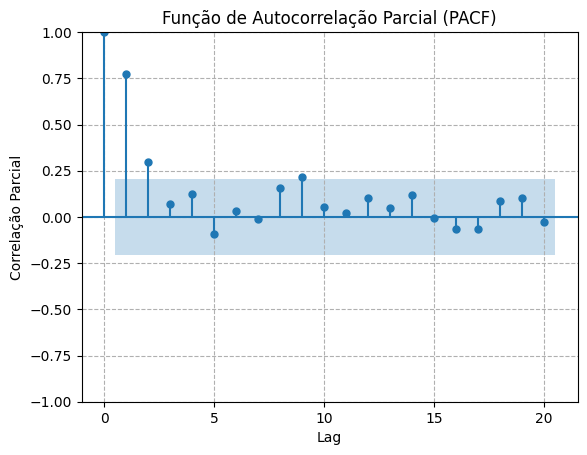

In [109]:
# Agrupar por data e somar vendas (caso haja múltiplos produtos)
ts_vendas = df.groupby("periodo")["venda"].sum().sort_index()

# Plotar PACF (substitua ts_vendas por ts_produto se necessário)
plot_pacf(ts_vendas, lags=20, alpha=0.05, method='ols')  # alpha=0.05 → 95% confiança
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.xlabel('Lag')
plt.ylabel('Correlação Parcial')
plt.grid(linestyle='--')
plt.show()

In [114]:
#produtos mais vendidos
df.groupby("codigo")["venda"].sum().sort_values(ascending=False).head()

codigo
300000708    792703.0
1520002      752127.0
300000713    612551.0
300000711    574800.0
300000714    531167.0
Name: venda, dtype: float64

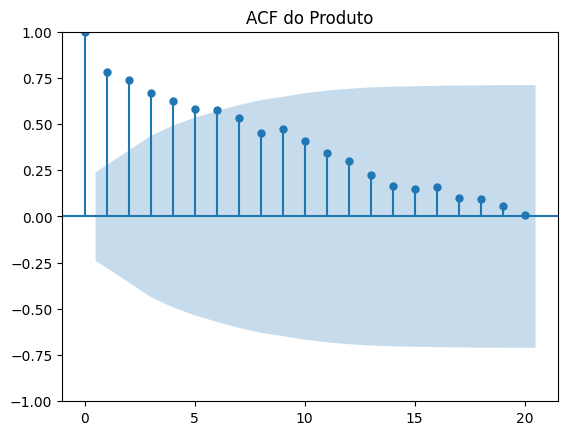

In [118]:
# Calcular ACF para um produto específico (ex.: primeiro da lista)
#produto_exemplo = produtos_validos[0]
ts_produto = df[df.codigo == 300000708].set_index('periodo')['venda'].sort_index()

plot_acf(ts_produto, lags=min(20, len(ts_produto)-1), alpha=0.05)
plt.title(f'ACF do Produto')
plt.show()

In [134]:
df["periodo"].astype("str")

0        2018-01
1        2018-01
2        2018-01
3        2018-01
4        2018-01
          ...   
13630    2025-08
13631    2025-08
13632    2025-08
13633    2025-08
13634    2025-08
Name: periodo, Length: 13635, dtype: object

In [135]:
pd.to_datetime(df["periodo"].astype("str"), format="%Y-%m")

0       2018-01-01
1       2018-01-01
2       2018-01-01
3       2018-01-01
4       2018-01-01
           ...    
13630   2025-08-01
13631   2025-08-01
13632   2025-08-01
13633   2025-08-01
13634   2025-08-01
Name: periodo, Length: 13635, dtype: datetime64[ns]

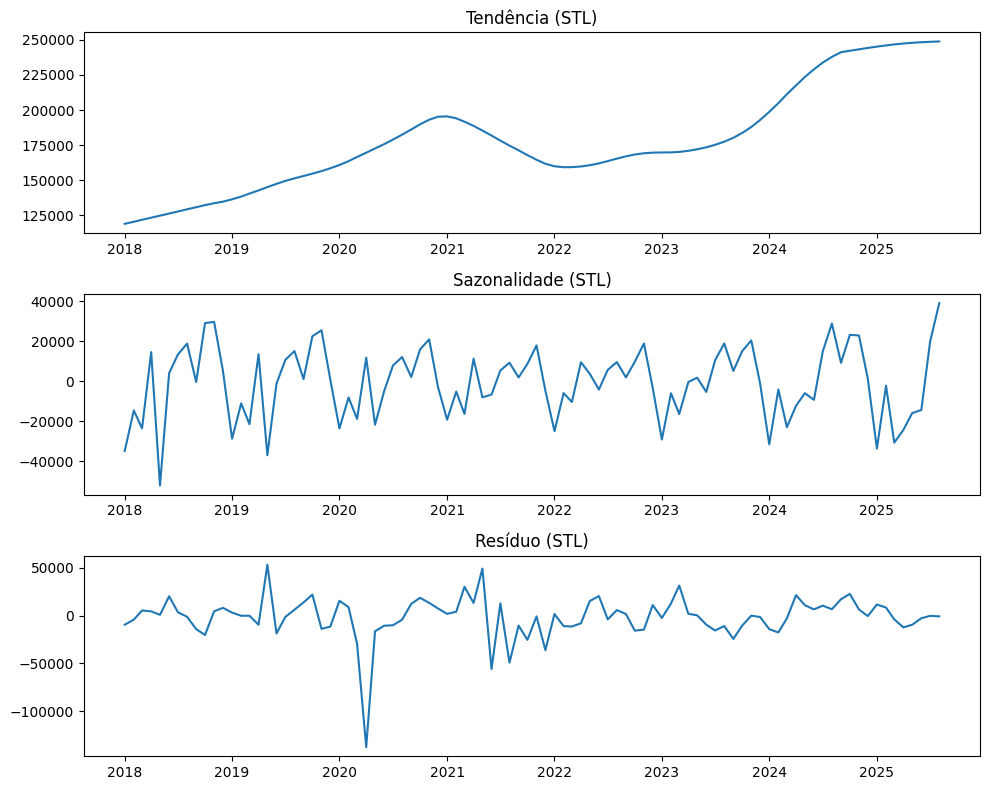

In [136]:
# criando a data completa
df["data"] = pd.to_datetime(df["periodo"].astype("str"), format="%Y-%m")

df_m = (
    df.dropna(subset=["data"])
      .set_index("data")
      .sort_index()
      .resample("MS")
      .agg({"venda":"sum"})
)

# Série de venda
ts = df_m["venda"].fillna(0)

# STL
stl = STL(ts, period=12, robust=True).fit()
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(311); ax1.plot(stl.trend.index, stl.trend.values); ax1.set_title("Tendência (STL)")
ax2 = fig.add_subplot(312); ax2.plot(stl.seasonal.index, stl.seasonal.values); ax2.set_title("Sazonalidade (STL)")
ax3 = fig.add_subplot(313); ax3.plot(stl.resid.index, stl.resid.values); ax3.set_title("Resíduo (STL)")
fig.tight_layout(); plt.show()

# Métrica de força de sazonalidade
var_res = np.nanvar(stl.resid.values)
var_seas_res = np.nanvar((stl.seasonal + stl.resid).values)
seasonality_strength = 1 - (var_res / var_seas_res) if var_seas_res > 0 else np.nan

# Ljung-Box (lag 12)
lj = acorr_ljungbox(ts, lags=[12], return_df=True)

In [137]:
# Métrica de força de sazonalidade
var_res = np.nanvar(stl.resid.values)
var_seas_res = np.nanvar((stl.seasonal + stl.resid).values)
seasonality_strength = 1 - (var_res / var_seas_res) if var_seas_res > 0 else np.nan

# Ljung-Box (lag 12)
lj = acorr_ljungbox(ts, lags=[12], return_df=True)
lj

,lb_stat,lb_pvalue
12,223.57024,4.312851e-41


## Mapa de Correlação

In [139]:
df.columns

Index(['periodo', 'codigo', 'venda', 'aquisicao_imob', 'contrucao_imobiliaria', 'IBC_atividade_economica', 'ind_custo_credito',
       'geral_ipca', 'ipca_artigos_residencia', 'reforma_ou_ampliacao', 'tax_desocupacao', 'inadimplencia', 'fabri_eletrodomesticos',
       'fabricacao_fogoes_refrig_maq_lavar_seca', 'fabri_outros_eletrodomesticos', 'mes', 'data'],
      dtype='object')

In [30]:
# "cod_ibge", " "codf_mil", "cod"
df_m = df.groupby(["periodo"]).agg(
    venda = ("venda", "sum")
).reset_index()

#aquisicao
aquisicao =  pd.read_csv("estatisticas\\aquisicao_imobiliaria(bilhao).csv", sep=";", parse_dates=["data"])
aquisicao["periodo"] = aquisicao.data.dt.to_period("M")
aquisicao["aquisicao_imob"] = aquisicao.aquisicao_imob.str.replace(",", ".").astype("float64")
df_m = df_m.merge(aquisicao[["aquisicao_imob",	"periodo"]], on="periodo", how="left")

construcao = pd.read_csv("estatisticas\\valor_de_construcao_imobiliaria(bilhão).csv", sep=";", parse_dates=["data"])
construcao["periodo"] = construcao.data.dt.to_period("M")
construcao["contrucao_imobiliaria"] = construcao.contrucao_imobiliaria.str.replace(",", ".").astype("float64")
df_m = df_m.merge(construcao[["contrucao_imobiliaria",	"periodo"]], on="periodo", how="left")

ibc = pd.read_csv("estatisticas\\ibc-br_atividade_economica(%).csv", sep=";")
ibc["data"] = pd.to_datetime(ibc.data, format="%d/%m/%Y")
ibc["periodo"] = ibc.data.dt.to_period("M")
ibc["IBC_atividade_economica"] = ibc.IBC_atividade_economica.str.replace(",", ".").astype("float64")
df_m = df_m.merge(ibc[["IBC_atividade_economica", "periodo"]], on="periodo", how="left")

custo_credito = pd.read_csv("estatisticas\\indicador_de_custo_do_credito(%).csv", sep=";")
custo_credito["data"] = pd.to_datetime(custo_credito.data, format="%d/%m/%Y")
custo_credito["periodo"] = custo_credito.data.dt.to_period("M")
custo_credito["ind_custo_credito"] = custo_credito.ind_custo_credito.str.replace(",", ".").astype("float64")
df_m = df_m.merge(custo_credito[["ind_custo_credito", "periodo"]], on="periodo", how="left")

ipca = pd.read_csv("estatisticas\\ipca_produtos(%).csv", sep=";")
ipca["data"] = pd.to_datetime(ipca.data, format="%d/%m/%Y")
ipca["periodo"] = ipca.data.dt.to_period("M")
ipca["geral_ipca"] = ipca.geral_ipca.str.replace(",", ".").astype("float64")
ipca["ipca_artigos_residencia"] = ipca.ipca_artigos_residencia.str.replace(",", ".").astype("float64")
df_m = df_m.merge(ipca[["geral_ipca", "ipca_artigos_residencia", "periodo"]], on="periodo", how="left")

reforma = pd.read_csv("estatisticas\\reforma-ou-ampliao(bilhao).csv", sep=";", parse_dates=["data"])
reforma["periodo"] = reforma.data.dt.to_period("M")
reforma["reforma_ou_ampliacao"] = reforma.reforma_ou_ampliacao.str.replace(",", ".").astype("float64")
df_m = df_m.merge(reforma[["reforma_ou_ampliacao", "periodo"]], on="periodo", how="left")

desocupacao = pd.read_csv("estatisticas\\taxa_desocupacao(%).csv", sep=";")
desocupacao["data"] = pd.to_datetime(desocupacao.data, format="%d/%m/%Y")
desocupacao["periodo"] = desocupacao.data.dt.to_period("M")
desocupacao["tax_desocupacao"] = desocupacao.tax_desocupacao.str.replace(",", ".").astype("float64")
df_m = df_m.merge(desocupacao[["tax_desocupacao", "periodo"]], on="periodo", how="left")

inadimplencia = pd.read_csv("estatisticas\\inadimplencia.csv", sep=";")
inadimplencia["data"] = pd.to_datetime(inadimplencia.data, format="%d/%m/%Y")
inadimplencia["periodo"] = inadimplencia.data.dt.to_period("M")
inadimplencia["inadimplencia"] =  inadimplencia.inadimplencia.str.replace(",", ".").astype("float64")
df_m = df_m.merge(inadimplencia[["inadimplencia", "periodo"]], on="periodo", how="left")

prod_eletrodomestico = pd.read_excel("estatisticas\\producao_eletrodomesticos_process.xlsx", parse_dates=["data"])
prod_eletrodomestico["periodo"] = prod_eletrodomestico.data.dt.to_period("M")
df_m = df_m.merge(prod_eletrodomestico[["fabri_eletrodomesticos", "fabricacao_fogoes_refrig_maq_lavar_seca", "fabri_outros_eletrodomesticos","periodo"]], on="periodo", how="left")

concessao_credito = pd.read_csv("estatisticas\\concessao_credito_txjuros.csv", sep=";")
concessao_credito["data"] = pd.to_datetime(concessao_credito.data, format="%d/%m/%Y")
concessao_credito["periodo"] = concessao_credito.data.dt.to_period("M")
concessao_credito["taxa_media_mensal_operacoes_credito"] = concessao_credito.taxa_media_mensal_operacoes_credito.str.replace(",", ".").astype("float64")
concessao_credito["concessoes_crédito_milhoes"] = concessao_credito.concessoes_crédito_milhoes.astype("float64")
df_m = df_m.merge(concessao_credito[["concessoes_crédito_milhoes", "taxa_media_mensal_operacoes_credito", "periodo"]], on="periodo", how="left")

consumo_energia = pd.read_csv("estatisticas\\consumo_energia.csv", sep=";")
consumo_energia["data"] = pd.to_datetime(consumo_energia.data, format="%d/%m/%Y")
consumo_energia["periodo"] = consumo_energia.data.dt.to_period("M")
consumo_energia["consumo_eletrico_quantGWh"] = consumo_energia.consumo_eletrico_quantGWh.str.replace(",", ".").astype("float64")
df_m = df_m.merge(consumo_energia[["consumo_eletrico_quantGWh",	"periodo"]], on="periodo", how="left")

intecao_consumo = pd.read_csv("estatisticas\\intencao_consumo_familia.csv", sep=";")
intecao_consumo["data"] = pd.to_datetime(intecao_consumo.data, format="%d/%m/%Y")
intecao_consumo["periodo"] = intecao_consumo.data.dt.to_period("M")
intecao_consumo["intencao_consumo_familia"] = intecao_consumo.intencao_consumo_familia.str.replace(",", ".").astype("float64")
df_m = df_m.merge(intecao_consumo[["intencao_consumo_familia", "periodo"]], on="periodo", how="left")

rendimento_medio = pd.read_csv("estatisticas\\rendimento_real_medio_mensal.csv", sep=";")
rendimento_medio["data"] = pd.to_datetime(rendimento_medio.data, format="%d/%m/%Y")
rendimento_medio["periodo"] = rendimento_medio.data.dt.to_period("M")
rendimento_medio["paridade_compra_salario"] = rendimento_medio.paridade_compra_salario.str.replace(",", ".").astype("float64")
df_m = df_m.merge(rendimento_medio[["rendimento_real_medio", "renda_nacional_disponivel_mi", "paridade_compra_salario", "periodo"]], on="periodo", how="left")

endividamento_fami = pd.read_csv("estatisticas\\endividamento_familia.csv", sep=";")
endividamento_fami["data"] = pd.to_datetime(endividamento_fami.data, format="%d/%m/%Y")
endividamento_fami["periodo"] = endividamento_fami.data.dt.to_period("M")
endividamento_fami["endividamento_familias"] = endividamento_fami.endividamento_familias.str.replace(",", ".").astype("float64")
df_m = df_m.merge(endividamento_fami[["endividamento_familias", "periodo"]], on="periodo", how="left")

df_m = df_m.set_index("periodo").sort_index()

<positron-console-cell-30>:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


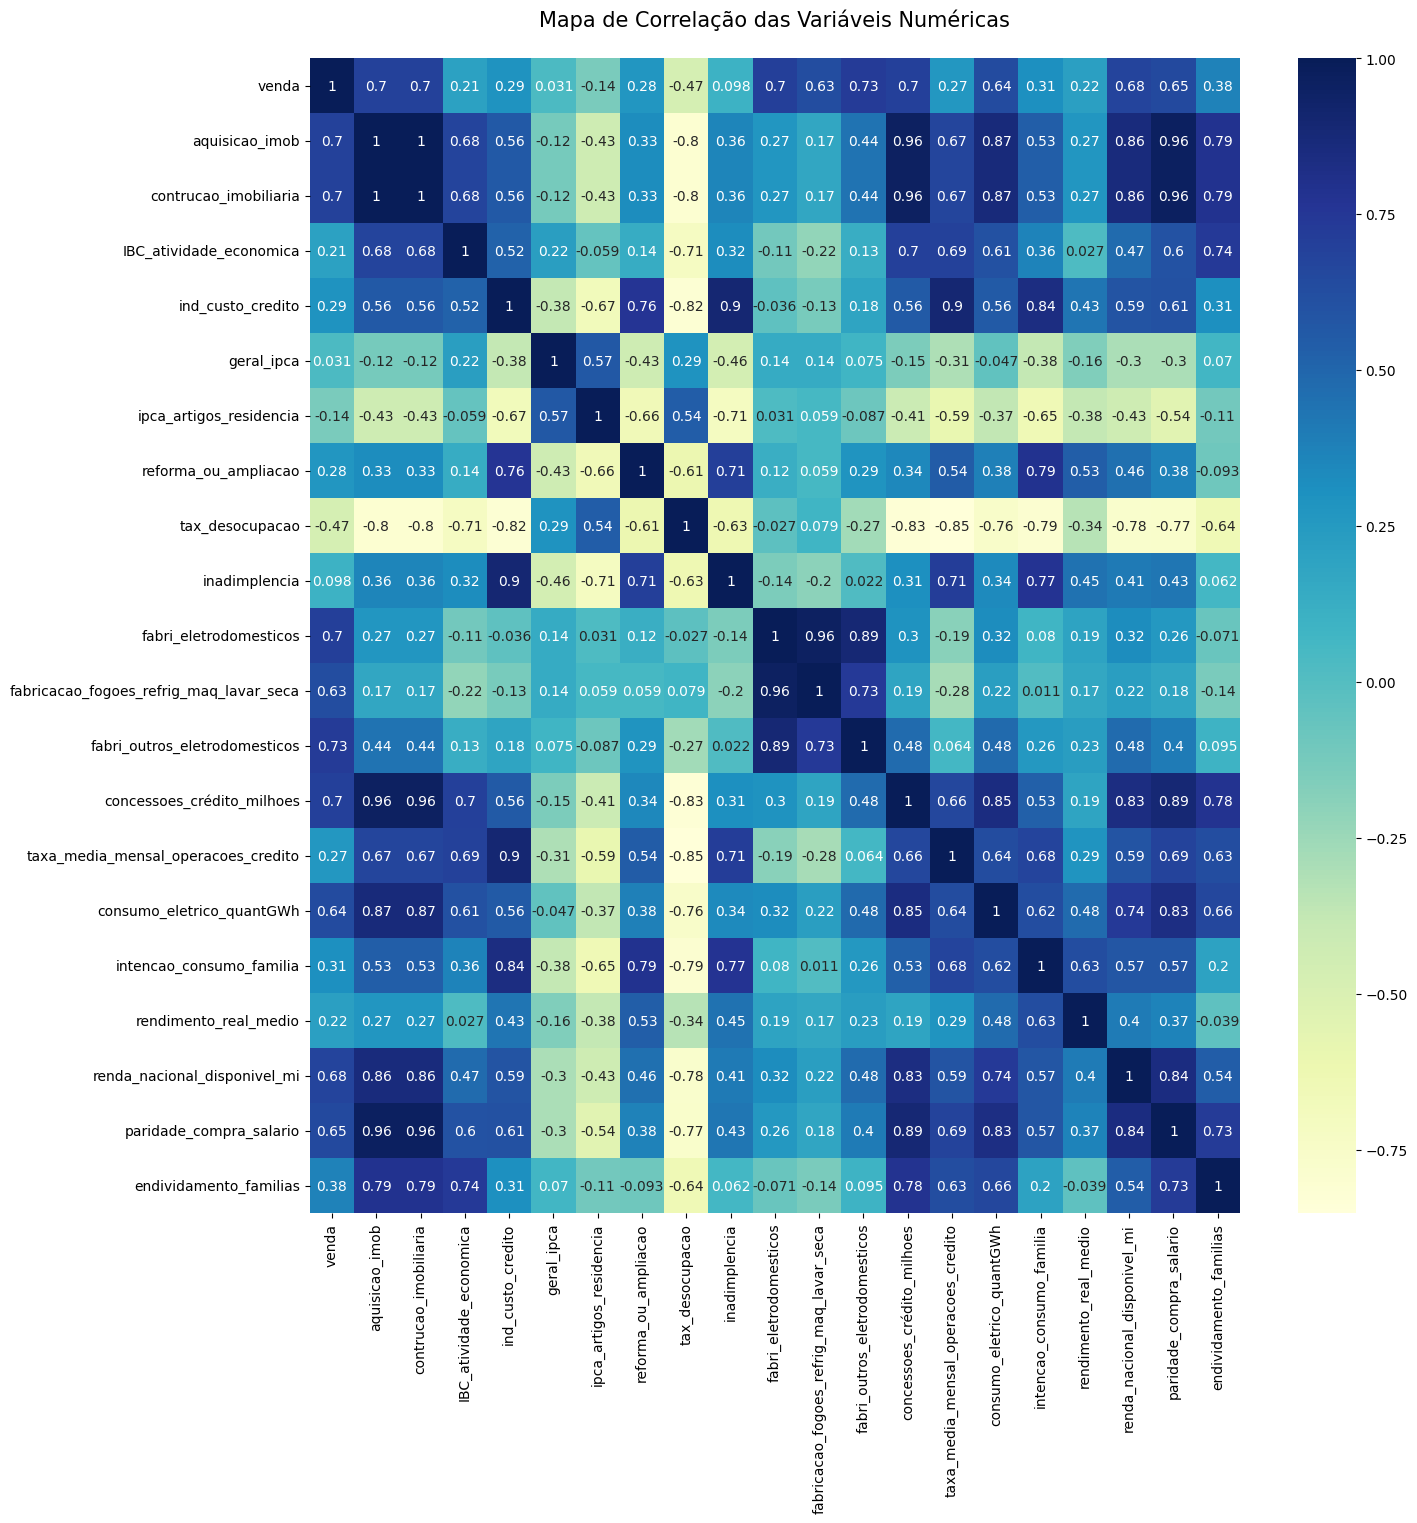

In [35]:
# Heatmap
plt.figure(figsize = (15, 15))
sns.heatmap(df_m.corr("spearman"), annot = True, cmap = "YlGnBu")
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

In [38]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 92 entries, 2018-01 to 2025-08
Freq: M
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   venda                                    92 non-null     float64
 1   aquisicao_imob                           91 non-null     float64
 2   contrucao_imobiliaria                    91 non-null     float64
 3   IBC_atividade_economica                  92 non-null     float64
 4   ind_custo_credito                        92 non-null     float64
 5   geral_ipca                               68 non-null     float64
 6   ipca_artigos_residencia                  68 non-null     float64
 7   reforma_ou_ampliacao                     79 non-null     float64
 8   tax_desocupacao                          92 non-null     float64
 9   inadimplencia                            90 non-null     float64
 10  fabri_eletrodomesticos          

In [36]:
df_m.to_excel("vendas_e_variaveis_socioeconomicas.xlsx")